# Pronostico probabilistico para temperatura maxima.

## ¿Como generar un pronóstico probabilistico para la semana 2 con python?

En este tutorial vamos a explorar como generar una visualización de pronóstico:

- Vamos a elegir un dominio reducido
- Tomar datos diarios de temperatura máxima correspondiende a la semana 2
- Elegir un umbral de temperatura máxima y calcular la probabilidad de que haya días que excedan ese umbral
- Graficar

In [1]:
# Como siempre, partimos importando los modulos a utilizar:
%matplotlib inline
import xarray as xr
import s3fs
import netCDF4
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import os
import sys
import datetime
from scipy.stats import norm
from scipy.optimize import curve_fit
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt


Algunas funciones que usamos

In [2]:
def preprocess_ds(ds):
    ds = ds.assign_coords(S = ds.time.values[0])
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds

Este ejemplo es para el sur de Sudamérica en febrero. Vamos a tomar dos fechas de inicialización diferente para pronosticar las chances de días con temperatura mǽxima por encima de 25 grados en la semana del 15 al 21 de febrero de 2018

In [3]:
variable = 'tmax'
umbral = 25
lat_n = -35
lat_s = -60
lon_w = -80
lon_e = -50
os.system('mkdir -p ./tmp')
# fechas de referencia para iniciar los pronósticos
ref_date = [datetime.datetime.strptime('20180131', "%Y%m%d"), datetime.datetime.strptime('20180207', "%Y%m%d")]

Descargamos los datos

In [4]:
# DATOS CORREGIDOS
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
modelo = 'GEFSv12_corr'
for i in ref_date:
    PATH = tforecast + '/' + modelo + '/' + variable + '/' + i.strftime('%Y') + '/' + i.strftime('%Y%m%d') + '/'            
    # Listamos todos los archivos dentro del bucket + PATH
    awsfiles = fs.ls('s3://' + BUCKET_NAME + '/' + PATH)
    for ii, awsfile in enumerate(awsfiles):
        if not os.path.isfile('./tmp/corr_' + variable + '_' + i.strftime('%Y%m%d') + '_' + str(ii) + '.nc4'):
            print('Extrayendo datos del archivo:')
            print(awsfile)
            with fs.open(awsfile) as f:
                gefs = xr.open_dataset(f)
                gefs = gefs.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e))
                gefs = gefs.assign_coords(M= ii)
                ds = gefs[variable]
                ds.to_netcdf('./tmp/corr_' + variable + '_' + i.strftime('%Y%m%d') + '_' + str(ii) + '.nc4')
                f.close()


Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_c00.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p01.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p02.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p03.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p04.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p05.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p06.nc
Extrayendo datos del archivo:
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2018/20180131/tmax_20180131_p07.nc
Extrayendo datos del archivo:
sissa-forecast-dat

Acomodamos los datos en funcion de los miembros del ensamble y la fecha

In [5]:
#abro los datos corregidos
ds = []
for i in ref_date:
    aux = xr.open_mfdataset('./tmp/corr_' + variable + '_' + i.strftime('%Y%m%d') + '*.nc4', engine='netcdf4', combine='nested', concat_dim=['M'], preprocess=preprocess_ds)
    ds.append(aux)

ds = xr.concat(ds, dim='S')
print(ds)

<xarray.Dataset>
Dimensions:   (leadtime: 34, lat: 85, lon: 121, M: 11, S: 2)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 0 days 1 days ... 32 days 33 days
  * lat       (lat) float64 -35.0 -35.25 -35.5 -35.75 ... -55.5 -55.75 -56.0
  * lon       (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -50.5 -50.25 -50.0
  * M         (M) int32 0 1 10 2 3 4 5 6 7 8 9
  * S         (S) datetime64[ns] 2018-01-31 2018-02-07
Data variables:
    tmax      (S, M, leadtime, lat, lon) float64 dask.array<chunksize=(1, 1, 34, 85, 121), meta=np.ndarray>


Miramos cuántos días de la semana se supera el umbral y la probabilidad de superarlo de 1 a 7 días

In [6]:
prob2 = []
dias = []
for i in ds.S.values:
    aux = (ds.sel(S=i, leadtime = slice(np.datetime64('2018-02-15', '[D]') - i, np.datetime64('2018-02-21', '[D]') - i)) > umbral).sum('leadtime') 
    dias.append(aux)
dias = xr.concat(dias, dim='S').compute()
for i in dias.S.values:
    prob = []
    for j in np.arange(1, 8, 1):
        aux = (dias.sel(S=i) >= j).sum('M') / len(dias.M.values) * 100
        prob.append(aux)
    prob = xr.concat(prob, dim='dias')
    prob['dias'] = np.arange(1, 8, 1)
    prob2.append(prob)
prob2 = xr.concat(prob2, dim='S')

Grafico la probabilidad de superar los 25 grados 1 día, 4 días y 7 días

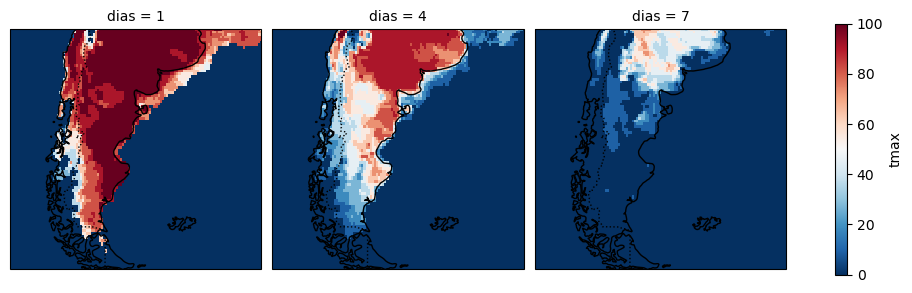

In [7]:
p = prob2[variable].isel(S=0).sel(dias=[1, 4, 7]).plot(col='dias',  cmap='RdBu_r', subplot_kws={"projection": ccrs.Mercator(-60)}, transform=ccrs.PlateCarree())

for ax in p.axs.flat:
    ax.coastlines()
    ax.set_extent([-80, -50, -55, -35], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

Repito para el otro pronóstico

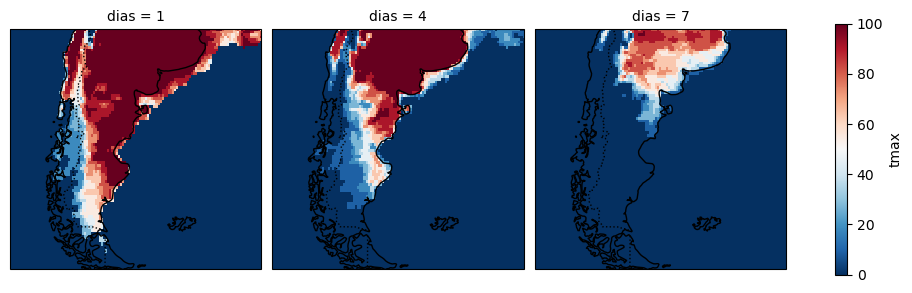

In [8]:
p = prob2[variable].isel(S=1).sel(dias=[1, 4, 7]).plot(col='dias', cmap='RdBu_r', subplot_kws={"projection": ccrs.Mercator(-60)}, transform=ccrs.PlateCarree())

for ax in p.axs.flat:
    ax.coastlines()
    ax.set_extent([-80, -50, -55, -35], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

Bajo las observaciones para esa semana y grafico el número de días con tmax mayor a 25 grados

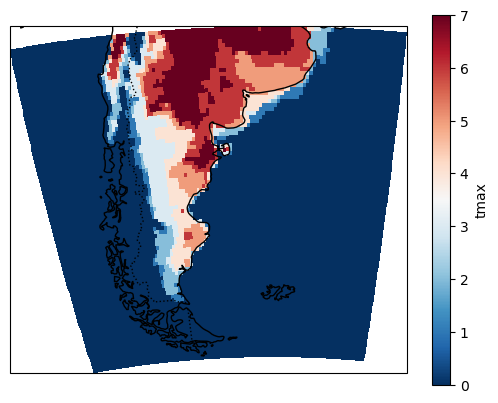

In [9]:
# Obtenemos los datos de ERA5
fs = s3fs.S3FileSystem(anon=True)
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'ERA5'
modelo = 'ERA5'
list_df = []
PATH = tforecast + '/' + variable 
awsfile = fs.ls('s3://' + BUCKET_NAME + '/' + PATH + '/2018.nc')
with fs.open(awsfile[0]) as f:
    era = xr.open_dataset(f)
    era = era.sel(latitude=slice(lat_n, lat_s), longitude=slice(lon_w, lon_e), time=slice('2018-02-15', '2018-02-21'))
    era = (era > umbral).sum('time')
    p = era[variable].plot(cmap='RdBu_r', subplot_kws={"projection": ccrs.Orthographic(-60, -30)}, transform=ccrs.PlateCarree(), vmin=0, vmax=7)
    p.axes.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
    p.axes.coastlines()